# Bollinger's analysis and position limits

In [64]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn')

## Getting csv data with historical ask, bid values

In [65]:
csv_filepath = 'round_1_data/prices_round_1_day_0.csv'
csv_trade = pd.read_csv(csv_filepath, sep=';')

In [66]:
df_banana = csv_trade[csv_trade['product'] == 'BANANAS'].sort_values(by=["timestamp"])
df_pearl = csv_trade[csv_trade['product'] == 'PEARLS'].sort_values(by=["timestamp"])

In [67]:
df_pearl.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,PEARLS,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
2,0,100,PEARLS,9996,1,9995.0,30.0,NaN,NaN,10002,6,10004.0,1.0,10005.0,30.0,9999.0,2.0
4,0,200,PEARLS,9996,1,9995.0,21.0,NaN,NaN,10004,1,10005.0,21.0,NaN,NaN,10000.0,2.0
6,0,300,PEARLS,9996,2,9995.0,23.0,NaN,NaN,9998,3,10004.0,2.0,10005.0,23.0,9997.0,2.0
8,0,400,PEARLS,9998,5,9996.0,2.0,9995.0,23.0,10004,2,10005.0,23.0,NaN,NaN,10001.0,-4.0


In [68]:
df_banana.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
19991,0,999500,BANANAS,4869,28,NaN,NaN,NaN,NaN,4872,6,4874.0,6.0,4876.0,28.0,4870.5,126424.0
19993,0,999600,BANANAS,4869,29,NaN,NaN,NaN,NaN,4870,1,4874.0,3.0,4876.0,29.0,4869.5,125984.0
19995,0,999700,BANANAS,4875,1,4870.0,2.0,4869.0,24.0,4876,26,NaN,NaN,NaN,NaN,4875.5,123508.0
19997,0,999800,BANANAS,4869,27,NaN,NaN,NaN,NaN,4876,27,NaN,NaN,NaN,NaN,4872.5,123648.0
19999,0,999900,BANANAS,4870,23,NaN,NaN,NaN,NaN,4876,2,4877.0,21.0,NaN,NaN,4873.0,121460.0


In [69]:
csv_trade.groupby('product').agg({'mid_price': ['mean', 'std', 'min', 'max']})

mid_price                           
               mean       std     min      max
product                                       
BANANAS  4889.50765  7.622357  4869.5   4911.0
PEARLS   9999.99975  1.496228  9996.5  10003.5

In [70]:
csv_filepath_trades = 'round_1_data/trades_round_1_day_0_nn.csv'
csv_filepath_trades = pd.read_csv(csv_filepath_trades, sep=';')
csv_filepath_trades.head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,100,NaN,NaN,PEARLS,SEASHELLS,10002.0,1
1,300,NaN,NaN,PEARLS,SEASHELLS,9998.0,2
2,300,NaN,NaN,PEARLS,SEASHELLS,9998.0,1
3,400,NaN,NaN,BANANAS,SEASHELLS,4899.0,9
4,500,NaN,NaN,BANANAS,SEASHELLS,4899.0,1


In [71]:
csv_filepath_trades.groupby('quantity').agg({'price': ['mean', 'std', 'min', 'max']})

price                              
                 mean          std     min      max
quantity                                           
0         7078.857143  2733.103695  4886.0  10002.0
1         7237.036061  2547.409427  4870.0  10005.0
2         7609.809636  2551.385762  4869.0  10005.0
3         7585.582569  2557.039769  4875.0  10005.0
4         7979.016949  2505.803449  4869.0  10005.0
5         7559.959799  2558.997541  4873.0  10005.0
6         7596.258824  2564.926520  4876.0  10005.0
7         6696.560976  2457.709242  4872.0  10005.0
8         7099.689189  2549.300086  4872.0  10005.0
9         6461.096154  2382.042280  4875.0  10005.0
10        7026.636364  2543.883830  4875.0  10005.0
11        5560.710526  1750.175202  4873.0  10005.0
12        5855.243243  2030.579589  4873.0  10005.0
13        4887.550000     9.190813  4870.0   4906.0
14        4891.200000     9.267455  4877.0   4910.0
15        4889.444444     7.247605  4874.0   4898.0
16        4893.750000     6.606274  4884.0   4906.0
17        4887.909091     9.459963  4875.0   4905.0
18        4886.875000     6.800735  4875.0   4901.0
19        4888.692308     7.145915  4879.0   4901.0
20        4888.636364    12.167767  4874.0   4908.0

## Bollinger's band Analysis 
### First for Bananas

In [97]:
def SMA(data, period, column = 'mid_price'):
    return data[column].rolling(window = period).mean()

# Setting up Bananas DF
df_banana['SMA15'] = SMA(df_banana, 15)
df_banana['SMA50'] = SMA(df_banana, 50)
df_banana['SMA80'] = SMA(df_banana, 80)
df_banana['stdev'] = df_banana.mid_price.rolling(window = 15).std()
df_banana['Upper'] = df_banana.SMA15 + 1*df_banana.stdev
df_banana['Lower'] = df_banana.SMA15 - 1*df_banana.stdev 
 # Buy & Sell signals
df_banana['Buy_Signal'] = np.where(df_banana.Lower > df_banana.mid_price, True, False)
print("count BUY signal \n", df_banana.Buy_Signal.value_counts())
df_banana['Sell_Signal'] = np.where(df_banana.Upper < df_banana.mid_price, True, False)
print("count SELL signal \n", df_banana.Sell_Signal.value_counts())

count BUY signal 
 False    8327
True     1673
Name: Buy_Signal, dtype: int64
count SELL signal 
 False    8413
True     1587
Name: Sell_Signal, dtype: int64


<IPython.core.display.Javascript object>


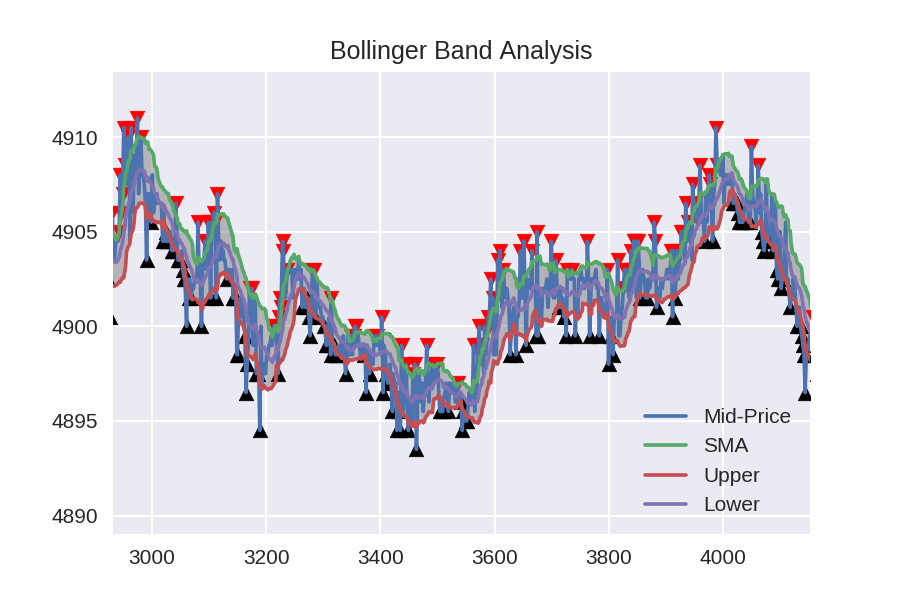

In [98]:
plt.figure(figsize = (6,4))
plt.plot(df_banana[['mid_price', 'Upper', 'Lower', 'SMA15']])
plt.fill_between(df_banana.index, df_banana.Upper, df_banana.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_banana.index[df_banana.Buy_Signal], df_banana[df_banana.Buy_Signal].mid_price, marker = '^', color = 'black')
plt.scatter(df_banana.index[df_banana.Sell_Signal], df_banana[df_banana.Sell_Signal].mid_price, marker = 'v', color = 'red')
plt.title('Bollinger Band Analysis')
plt.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])
plt.show()

In [100]:
def hurst_exponent(data, max_lag = 40):
    values = data.values
    lags = np.arange(1, max_lag + 1)
    tau = [np.std(np.subtract(values[lag:], values[:-lag]))
          for lag in lags]
    poly = np.polyfit(np.log10(lags), np.log10(tau), 1)
    print("Hurst exponent found ", poly[0])
    print("Is it bullish ", poly[0] > 0.5)
    
for max_lag in np.arange(20, 1000, 50):
    print("max_lag ", max_lag)
    hurst_exponent(df_banana.mid_price, max_lag=max_lag)

max_lag  20
Hurst exponent found  0.12863327788916218
Is it bullish  False
max_lag  70
Hurst exponent found  0.21229816924145675
Is it bullish  False
max_lag  120
Hurst exponent found  0.25229266387688143
Is it bullish  False
max_lag  170
Hurst exponent found  0.2729689744707743
Is it bullish  False
max_lag  220
Hurst exponent found  0.2859904466970441
Is it bullish  False
max_lag  270
Hurst exponent found  0.29547938237556587
Is it bullish  False
max_lag  320
Hurst exponent found  0.3013900679477424
Is it bullish  False
max_lag  370
Hurst exponent found  0.30464595150421536
Is it bullish  False
max_lag  420
Hurst exponent found  0.30569363730943827
Is it bullish  False
max_lag  470
Hurst exponent found  0.30536625182846633
Is it bullish  False
max_lag  520
Hurst exponent found  0.30418892848515094
Is it bullish  False
max_lag  570
Hurst exponent found  0.30255350417469584
Is it bullish  False
max_lag  620
Hurst exponent found  0.3017082897103556
Is it bullish  False
max_lag  670
Hurst

# Statistics for each Volume Level Ratio

In [91]:
# bid ratios
df_banana["spread"] = df_banana.ask_price_1 - df_banana.bid_price_1
df_banana["l1_ratio"] = df_banana.bid_volume_1 / df_banana.ask_volume_1
df_banana["l2_ratio"] = df_banana.bid_volume_2 / df_banana.ask_volume_2
df_banana["l3_ratio"] = df_banana.bid_volume_3 / df_banana.ask_volume_3

In [92]:
metrics = ['count', 'mean', 'std', 'quantile']
df_banana.groupby("spread").agg({'l1_ratio': metrics, 'l2_ratio': metrics, 'l3_ratio': metrics})

l1_ratio                                l2_ratio                      \
          count      mean        std  quantile    count      mean       std   
spread                                                                        
1           933  7.776158  10.920546  1.000000      185  1.869402  4.516967   
2           559  1.632693   4.409964  0.142857      107  2.174921  4.560968   
3           251  7.189523   7.506434  5.600000       30  0.986551  0.232071   
4           542  2.718754   5.334885  0.400000      228  0.938606  0.019490   
5          1434  6.278631   6.507320  4.000000      220  1.059921  0.021307   
6          3482  5.368042   9.105688  0.409091        0       NaN       NaN   
7          2799  0.998032   0.008685  1.000000        0       NaN       NaN   

                 l3_ratio                    
        quantile    count mean std quantile  
spread                                       
1       1.037037        0  NaN NaN      NaN  
2       1.000000        0  NaN NaN      NaN  
3       1.050000        0  NaN NaN      NaN  
4       0.933333        0  NaN NaN      NaN  
5       1.050000        0  NaN NaN      NaN  
6            NaN        0  NaN NaN      NaN  
7            NaN        0  NaN NaN      NaN

In [93]:
# bid ratios
# df_banana["l1_ratio"] = df_banana.bid_volume_1 / df_banana.ask_volume_1
# df_banana["l2_ratio"] = df_banana.bid_volume_2 / df_banana.ask_volume_2
# df_banana["l3_ratio"] = df_banana.bid_volume_3 / df_banana.ask_volume_3

df_banana['l1_ge_one'] = np.where(df_banana.l1_ratio > 1, True, False) # bullish
df_banana['l1_le_one'] = np.where(df_banana.l1_ratio < 1, True, False)

for col, verbose in zip(["l1_ratio", "l2_ratio", "l3_ratio"], ["LEVEL 1", "LEVEL 2", "LEVEL 3"]):
    print("Does {} has zeros: {}".format(col, df_banana[col].eq(0).any()))
    indicator_buy = df_banana['Buy_Signal'] & df_banana[col]
    print("count BUY signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_buy.value_counts()))
    indicator_sell = df_banana['Sell_Signal'] & df_banana[col]
    print("count SELL signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_sell.value_counts()))
    print("------ TEST -------")

print("------ USED HERE -------")
print("SMA & Volume Momentum for 1st LEVEL")
sma_and_volume_buy = df_banana['Buy_Signal'] & df_banana['l1_ge_one']
print("count BUY signal (SMA & Volume Momentum) \n", sma_and_volume_buy.value_counts())
sma_and_volume_sell = df_banana['Sell_Signal'] & df_banana['l1_le_one']
print("count SELL signal (SMA & Volume Momentum) \n", sma_and_volume_sell.value_counts())

Does l1_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 1
 False    9669
True      331
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 1
 False    9642
True      358
dtype: int64
------ TEST -------
Does l2_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 2
 False    9978
True       22
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 2
 False    9959
True       41
dtype: int64
------ TEST -------
Does l3_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 3
 False    10000
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 3
 False    10000
dtype: int64
------ TEST -------
------ USED HERE -------
SMA & Volume Momentum for 1st LEVEL
count BUY signal (SMA & Volume Momentum) 
 False    9694
True      306
dtype: int64
count SELL signal (SMA & Volume Momentum) 
 False    9673
True      327
dtype: int64


## Using SMA 15 and Volume as Indicator

<IPython.core.display.Javascript object>


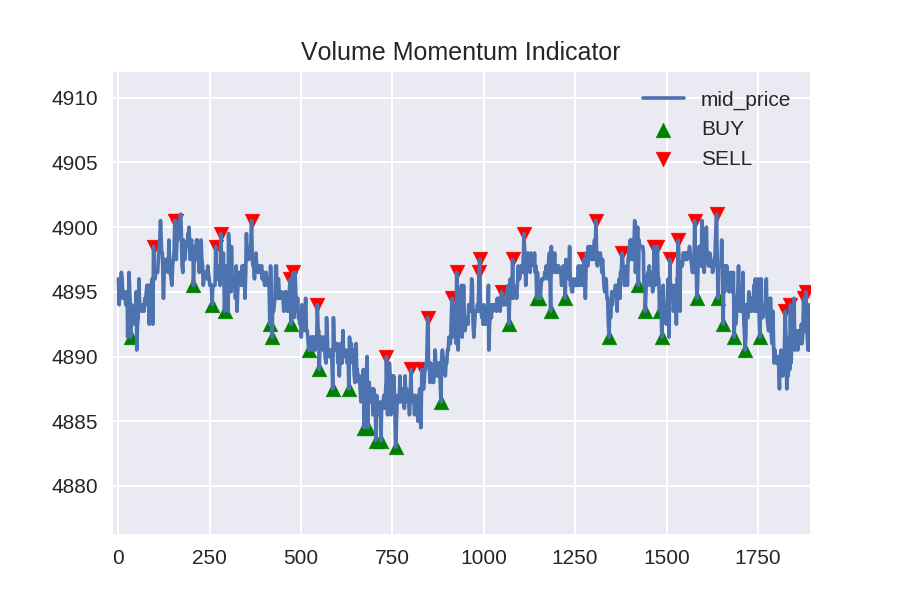

In [94]:
plt.figure(figsize = (6,4))
plt.plot(df_banana[['mid_price']])
#plt.fill_between(df_banana.index, df_banana.Upper, df_banana.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_banana[sma_and_volume_buy].index,df_banana[sma_and_volume_buy].mid_price, marker = '^', color = 'green')
plt.scatter(df_banana[sma_and_volume_sell].index, df_banana[sma_and_volume_sell].mid_price, marker = 'v', color = 'red')
plt.title('Volume Momentum Indicator')
plt.legend(["mid_price", "BUY", "SELL"])

## Analysis using MACD

In [129]:
def EWM(data, span_size, column = 'mid_price'):
    ewm_mean = data[column].ewm(span = span_size, adjust=False).mean()
    ewm_std = data[column].ewm(span = span_size, adjust=False).std()
    return ewm_mean, ewm_std

# Setting up Bananas DF
df_banana['ewm_12'], df_banana["ewm_12_std"] = EWM(df_banana, 12)
df_banana['ewm_26'], df_banana["ewm_26_std"] = EWM(df_banana, 26)
df_banana['macd'] = df_banana["ewm_12"] - df_banana["ewm_26"]
df_banana['signal'] = df_banana["macd"].ewm(span=9, adjust=False).mean() 
 # Buy & Sell signals
df_banana['macd_buy'] = np.where(df_banana.macd > df_banana.signal, True, False)
print("count BULLISH signal \n", df_banana.macd_buy.value_counts())
df_banana['macd_sell'] = np.where(df_banana.macd < df_banana.signal, True, False)
print("count BEARING signal \n", df_banana.macd_sell.value_counts())

count BULLISH signal 
 False    5062
True     4938
Name: macd_buy, dtype: int64
count BEARING signal 
 True     5061
False    4939
Name: macd_sell, dtype: int64


<IPython.core.display.Javascript object>


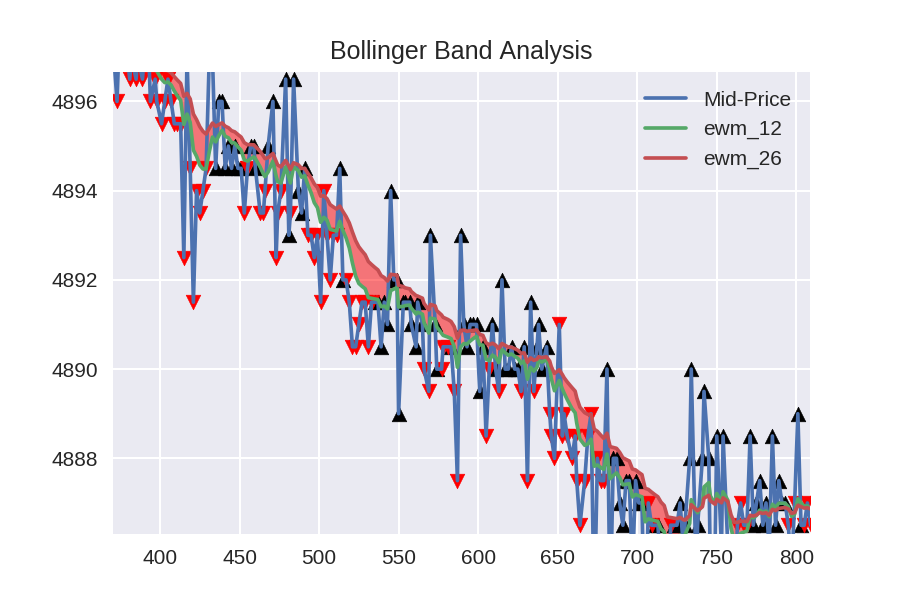

In [130]:
plt.figure(figsize = (6,4))
plt.plot(df_banana[['mid_price', 'ewm_12', 'ewm_26']])
plt.fill_between(df_banana.index, df_banana.ewm_12, df_banana.ewm_26, where=df_banana.ewm_12>df_banana.ewm_26, color = 'green', alpha = 0.5)
plt.fill_between(df_banana.index, df_banana.ewm_12, df_banana.ewm_26, where=df_banana.ewm_12<df_banana.ewm_26, color = 'red', alpha = 0.5)
plt.scatter(df_banana.index[df_banana.macd_buy], df_banana[df_banana.macd_buy].mid_price, marker = '^', color = 'black')
plt.scatter(df_banana.index[df_banana.macd_sell], df_banana[df_banana.macd_sell].mid_price, marker = 'v', color = 'red')
plt.title('Bollinger Band Analysis')
plt.legend(['Mid-Price', 'ewm_12', 'ewm_26',])
plt.show()

### Now for pearls

In [85]:
def SMA(data, period, column = 'mid_price'):
    return data[column].rolling(window = period).mean()

# Setting up Bananas DF
df_pearl['SMA15'] = SMA(df_pearl, 15)
df_pearl['SMA50'] = SMA(df_pearl, 50)
df_pearl['SMA80'] = SMA(df_pearl, 80)
df_pearl['stdev'] = df_pearl.mid_price.rolling(window = 15).std()
df_pearl['Upper'] = df_pearl.SMA15 + 2*df_pearl.stdev # using 2 x standard deviation
df_pearl['Lower'] = df_pearl.SMA15 - 2*df_pearl.stdev
df_pearl['Buy_Signal'] = np.where(df_pearl.Lower > df_pearl.mid_price, True, False) # Buy & Sell signals
df_pearl['Sell_Signal'] = np.where(df_pearl.Upper < df_pearl.mid_price, True, False)

<IPython.core.display.Javascript object>


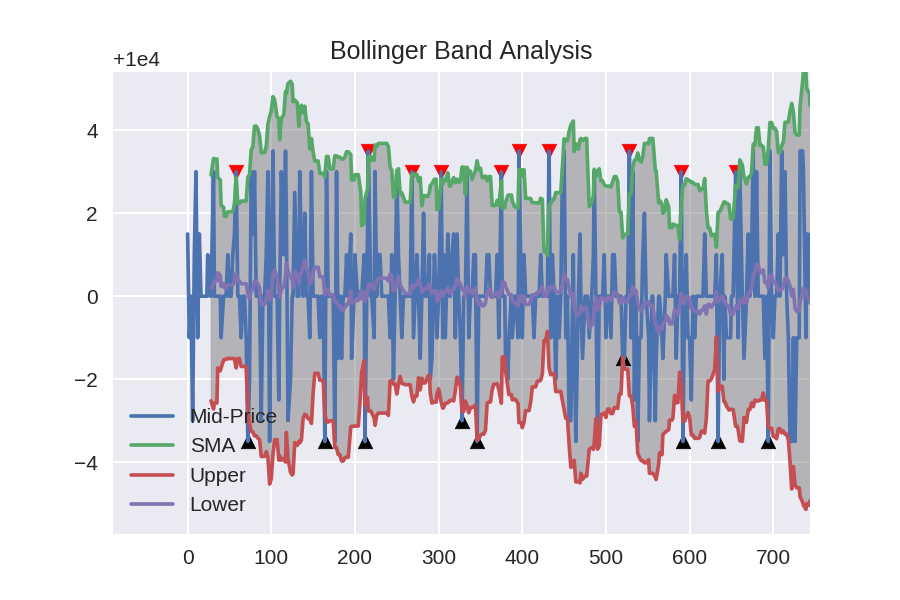

In [87]:
plt.figure(figsize = (6,4))
plt.plot(df_pearl[['mid_price', 'Upper', 'Lower', 'SMA15']])
plt.fill_between(df_pearl.index, df_pearl.Upper, df_pearl.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_pearl.index[df_pearl.Buy_Signal], df_pearl[df_pearl.Buy_Signal].mid_price, marker = '^', color = 'black')
plt.scatter(df_pearl.index[df_pearl.Sell_Signal], df_pearl[df_pearl.Sell_Signal].mid_price, marker = 'v', color = 'red')
plt.title('Bollinger Band Analysis')
plt.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])

In [88]:
# bid ratios
df_pearl["l1_ratio"] = df_pearl.bid_volume_1 / df_pearl.ask_volume_1
df_pearl["l2_ratio"] = df_pearl.bid_volume_2 / df_pearl.ask_volume_2
df_pearl["l3_ratio"] = df_pearl.bid_volume_3 / df_pearl.ask_volume_3

df_pearl['l1_ge_one'] = np.where(df_pearl.l1_ratio > 1, True, False) # bullish
df_pearl['l1_le_one'] = np.where(df_pearl.l1_ratio < 1, True, False)

for col, verbose in zip(["l1_ratio", "l2_ratio", "l3_ratio"], ["LEVEL 1", "LEVEL 2", "LEVEL 3"]):
    print("Does {} has zeros: {}".format(col, df_pearl[col].eq(0).any()))
    indicator_buy = df_pearl['Buy_Signal'] & df_pearl[col]
    print("count BUY signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_buy.value_counts()))
    indicator_sell = df_pearl['Sell_Signal'] & df_banana[col]
    print("count SELL signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_sell.value_counts()))
    print("------ TEST -------")

print("------ USED HERE -------")
print("SMA & Volume Momentum for 1st LEVEL")
sma_and_volume_buy = df_pearl['Buy_Signal'] & df_pearl['l1_ge_one']
print("count BUY signal (SMA & Volume Momentum) \n", sma_and_volume_buy.value_counts())
sma_and_volume_sell = df_pearl['Sell_Signal'] & df_pearl['l1_le_one']
print("count SELL signal (SMA & Volume Momentum) \n", sma_and_volume_sell.value_counts())


Does l1_ratio has zeros: True
count BUY signal (SMA & Volume Momentum) LEVEL 1
 False    9706
True      294
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 1
 False    20000
dtype: int64
------ TEST -------
Does l2_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 2
 False    9851
True      149
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 2
 False    20000
dtype: int64
------ TEST -------
Does l3_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 3
 False    10000
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 3
 False    20000
dtype: int64
------ TEST -------
------ USED HERE -------
SMA & Volume Momentum for 1st LEVEL
count BUY signal (SMA & Volume Momentum) 
 False    9818
True      182
dtype: int64
count SELL signal (SMA & Volume Momentum) 
 False    9816
True      184
dtype: int64


In [89]:
def hurst_exponent(data, max_lag = 40):
    values = data.values
    lags = np.arange(1, max_lag + 1)
    tau = [np.std(np.subtract(values[lag:], values[:-lag]))
          for lag in lags]
    poly = np.polyfit(np.log10(lags), np.log10(tau), 1)
    print("Hurst exponent found ", poly[0])
    print("Is it bullish ", poly[0] > 0.5)
    
for max_lag in np.arange(20, 200, 20):
    print("max_lag ", max_lag)
    hurst_exponent(df_pearl.mid_price, max_lag=max_lag)

max_lag  20
Hurst exponent found  -0.0015488773509538458
Is it bullish  False
max_lag  40
Hurst exponent found  -0.0003273767173373744
Is it bullish  False
max_lag  60
Hurst exponent found  -0.0007005281720424202
Is it bullish  False
max_lag  80
Hurst exponent found  -0.0008320456004551707
Is it bullish  False
max_lag  100
Hurst exponent found  -0.00025319589265529615
Is it bullish  False
max_lag  120
Hurst exponent found  -0.00035395297347020537
Is it bullish  False
max_lag  140
Hurst exponent found  -0.0005259653652936635
Is it bullish  False
max_lag  160
Hurst exponent found  -0.0005168733049749393
Is it bullish  False
max_lag  180
Hurst exponent found  -0.00045232968231885816
Is it bullish  False
